In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import requests
from talib import abstract

plt.style.use('fivethirtyeight')

In [2]:
data_request = requests.get('https://api3.binance.com/api/v3/klines?symbol=BTCBUSD&interval=1m&limit=1000')

In [3]:
bnb_btc_data = data_request.json()

In [4]:
dataframe = pd.DataFrame(data = {
    'open time': [],
    'open': [],
    'high': [],
    'low': [],
    'close': [],
})

for kline_item in bnb_btc_data :
    time = kline_item[0] / 1000
    row = {
        'open time': datetime.utcfromtimestamp(time),
        'open': float(kline_item[1]),
        'high': float(kline_item[2]),
        'low': float(kline_item[3]),
        'close': float(kline_item[4]),
    }
    dataframe = dataframe.append(row, ignore_index=True)


dataframe.head()

,open time,open,high,low,close
0,2021-10-26 19:45:00,62114.79,62114.79,62067.16,62067.17
1,2021-10-26 19:46:00,62067.16,62107.38,62067.16,62107.38
2,2021-10-26 19:47:00,62107.37,62119.14,62079.23,62119.12
3,2021-10-26 19:48:00,62119.11,62149.99,62119.11,62135.17
4,2021-10-26 19:49:00,62135.17,62135.17,62103.85,62103.86


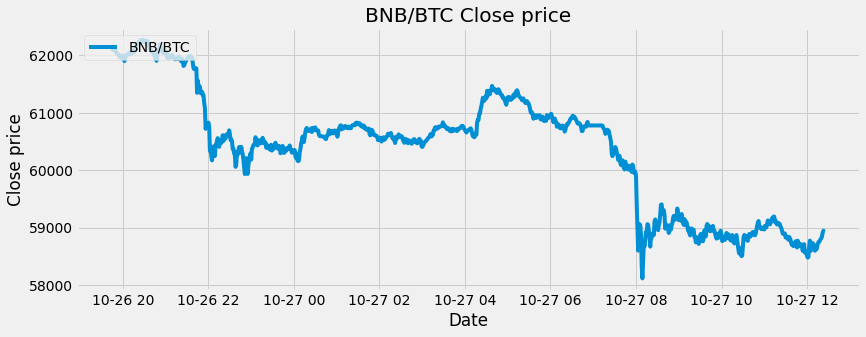

In [5]:
plt.figure(figsize = (12.5, 4.5))
plt.plot(dataframe['open time'], dataframe['close'], label = 'BNB/BTC')
plt.title('BNB/BTC Close price')
plt.xlabel('Date')
plt.ylabel('Close price')
plt.legend(loc='upper left')
plt.show()

In [6]:
sma30 = abstract.SMA(dataframe, timeperiod=30)
sma100 = abstract.SMA(dataframe, timeperiod=100)

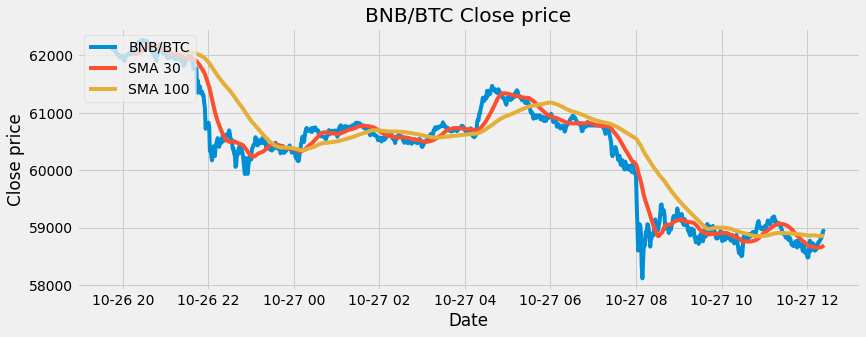

In [7]:
plt.figure(figsize = (12.5, 4.5))
plt.plot(dataframe['open time'], dataframe['close'], label = 'BNB/BTC')
plt.plot(dataframe['open time'], sma30, label = 'SMA 30')
plt.plot(dataframe['open time'], sma100, label = 'SMA 100')
plt.title('BNB/BTC Close price')
plt.xlabel('Date')
plt.ylabel('Close price')
plt.legend(loc='upper left')
plt.show()

In [8]:
dataframe['sma30'] = sma30 
dataframe['sma100'] = sma100

In [40]:
def buy_sell(data):
    sigPriceBuy = []
    sigPriceSell = []
    
    earns = pd.DataFrame(data = {
        'buy': [],
        'sell': [],
        'earn': [],
    })
    
    flag = 'sold'
    
    for i in range(len(data)):
        if data['sma30'][i] > data['sma100'][i]:
            if flag == 'sold':
                sigPriceBuy.append(data['close'][i])
                sigPriceSell.append(np.nan)
                flag = 'bought'
                earns = earns.append({ 'buy': data['close'][i] }, ignore_index=True)
            else:
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(np.nan)
                
        elif data['sma30'][i] < data['sma100'][i]:
            if flag == 'bought':
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(data['close'][i])
                flag = 'sold'
                rowIndex = earns.index[earns['buy'].notna() & earns['sell'].isna()]
#                 print(earns[rowIndex])
                earns.loc[rowIndex, 'sell'] = data['close'][i]
                earns.loc[rowIndex, 'earn'] = data['close'][i] - earns.loc[rowIndex, 'buy'] 

#                 earns.append({ 'buy': data['close'][i] }, ignore_index=True)
            else:
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(np.nan)
        else:
            sigPriceBuy.append(np.nan)
            sigPriceSell.append(np.nan)
    
    return (sigPriceBuy, sigPriceSell, earns)

In [43]:
result = buy_sell(dataframe)
dataframe['buy'] = result[0]
dataframe['sell'] = result[1]
earns = result[2]

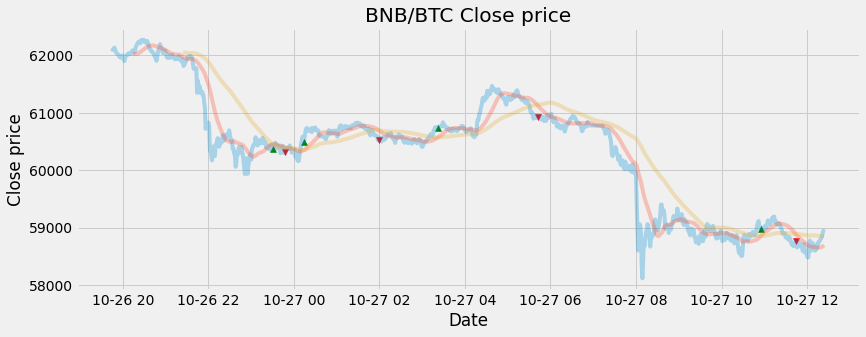

In [15]:
plt.figure(figsize = (12.5, 4.5))
plt.plot(dataframe['open time'], dataframe['close'], label = 'BNB/BTC', alpha=0.30)
plt.plot(dataframe['open time'], sma30, label = 'SMA 30', alpha=0.30)
plt.plot(dataframe['open time'], sma100, label = 'SMA 100', alpha=0.30)
plt.scatter(dataframe['open time'], dataframe['buy'], label = 'Buy', marker = '^', color = 'green')
plt.scatter(dataframe['open time'], dataframe['sell'], label = 'Sell', marker = 'v', color = 'red')
plt.title('BNB/BTC Close price')
plt.xlabel('Date')
plt.ylabel('Close price')
# plt.legend(loc='upper left')
plt.show()

In [54]:
print('Lucro', earns['earn'].sum())
total = earns['earn'].count()
print('Quantidade', earns['earn'].count())
wins = earns[earns['earn'] > 0].count()
p = (wins/total)['earn'] * 100
print(f'Porcentagem {p}%')
print('-------')

Lucro -8.460000000006403
Quantidade 4
Porcentagem 50.0%
-------
